# Customizing Object Detection Models With Lightweight PyTorch Code

[Tutorial on Medium](https://medium.com/@noel.B/customizing-object-detection-models-with-lightweight-pytorch-code-ed043e48a460)

The `torchvision.io` module provides utilities for decoding and encoding images and videos.

## Image Decoding

Torchvision currently supports decoding JPEG, PNG, WEBP and GIF images. JPEG decoding can also be done on CUDA GPUs (and is not working on macOS with arm64).

The main entry point is the [decode_image()](https://pytorch.org/vision/stable/generated/torchvision.io.decode_image.html#torchvision.io.decode_image) function, which you can use as an alternative to `PIL.Image.open()`. It will decode images straight into image Tensors, thus saving you the conversion and allowing you to run transforms/preproc natively on tensors.

In [150]:
import os
import yaml
import torch
import platform
import torchvision
import numpy as np
import pandas as pd
import PIL
import tqdm
import matplotlib.pyplot as plt
from pprint import pp

print(f"OS type: {os.name}")
print(f"Python Platform: {platform.platform(aliased=True, terse=False)}")
print(f"Python Version: {os.sys.version}")
print()

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchVision Version: {torchvision.__version__}")
print()

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")
print(f"Is cuda built? {torch.backends.cuda.is_built()}")
print(f"Is cuda available? {torch.cuda.is_available()}")
print()

# Set the device
device = (
    "mps"
    if torch.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")


OS type: posix
Python Platform: macOS-15.3-arm64-arm-64bit
Python Version: 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]

PyTorch Version: 2.5.1
TorchVision Version: 0.20.1

Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Is cuda built? False
Is cuda available? False

Using device: mps


In [ ]:
from torchvision.io import decode_image, decode_jpeg, read_image
from torchvision.utils import draw_bounding_boxes

In [120]:
path_to_data = os.path.join("..", "data", "split_yolo")
path_to_data

'../data/split_yolo'

In [121]:
yaml_path = os.path.join(path_to_data, "labels_txt", "dataset.yaml")
yaml_path


'../data/split_yolo/labels_txt/dataset.yaml'

In [136]:
def loadYAML(yaml_path: str) -> dict:
    with open(yaml_path, "r") as file:
        config_yaml = yaml.safe_load(file)
        
    return config_yaml

In [148]:
config_yaml = loadYAML(yaml_path)
train_images_path = os.path.join(path_to_data, config_yaml["train"])
print(f"Train images path  : {train_images_path}")

# list all the files in the directory
train_images = os.listdir(train_images_path)
print(f"Number of train images: {len(train_images)}")
print("First 5 train images:")
train_images[:5]

Train images path  : ../data/split_yolo/images/train
Number of train images: 1089
First 5 train images:


['bull_mastiff_0108.jpg',
 'bull_mastiff_0134.jpg',
 'bull_mastiff_0120.jpg',
 'dogo_argentino_0017.jpg',
 'fila_brasileiro_0039.jpg']

In [151]:
df_dataset = pd.DataFrame(train_images, columns=["image_name"])
df_dataset["image_path"] = df_dataset["image_name"].apply(lambda x: os.path.join(train_images_path, x))
df_dataset["image_id"] = df_dataset["image_name"].apply(lambda x: x.split(".")[0])
df_dataset.head()

,image_name,image_path,image_id
0,bull_mastiff_0108.jpg,../data/split_yolo/images/train/bull_mastiff_0...,bull_mastiff_0108
1,bull_mastiff_0134.jpg,../data/split_yolo/images/train/bull_mastiff_0...,bull_mastiff_0134
2,bull_mastiff_0120.jpg,../data/split_yolo/images/train/bull_mastiff_0...,bull_mastiff_0120
3,dogo_argentino_0017.jpg,../data/split_yolo/images/train/dogo_argentino...,dogo_argentino_0017
4,fila_brasileiro_0039.jpg,../data/split_yolo/images/train/fila_brasileir...,fila_brasileiro_0039


In [113]:
dirpath = os.walk(path_to_data)
root, dirs, files = next(dirpath)

print(dirs)
print(dirs[0])

['images', 'labels_txt', 'label_xml']
images


In [119]:
files

['.DS_Store']

In [114]:
images_path = os.path.join(root, dirs[0])
print(images_path)

../data/split_yolo/images


In [118]:
test = os.listdir(images_path)[0]
test

'test'

In [141]:
path_to_image = os.path.join(path_to_data, "images", "train", "american_pit_bull_terrier_0010.jpg")
path_to_image

'../data/split_yolo/images/train/american_pit_bull_terrier_0010.jpg'

In [16]:
path_to_annotation_cfg = "../data/split_yolo/labels_txt/dataset.yaml"
path_to_annotation_txt = "../data/split_yolo/labels_txt/train/american_pit_bull_terrier_0010.txt"

In [111]:
# annotations (list): List of dictionaries containing image paths and labels.
with open(path_to_annotation_cfg, "r") as file:
    annotations_yaml = yaml.load(file, Loader=yaml.FullLoader)

#os.path.split(annotations_yaml["path"])[0]
annotations_yaml["train"].split("..")[1]

'/images/train'

In [97]:
os.path?

Type:        module
String form: <module 'posixpath' (frozen)>
File:        /opt/homebrew/Caskroom/miniforge/base/envs/helloDogBreed/lib/python3.11/posixpath.py
Docstring:  
Common operations on Posix pathnames.

Instead of importing this module directly, import os and refer to
this module as os.path.  The "os.path" name is an alias for this
module on Posix systems; on other systems (e.g. Windows),
os.path provides the same operations in a manner specific to that
platform, and is an alias to another module (e.g. ntpath).

Some of this can actually be useful on non-Posix systems too, e.g.
for manipulation of the pathname component of URLs.

In [91]:
train_path

<generator object _walk at 0x169f1b290>

In [107]:
img = decode_image(path_to_image, mode="RGB")
print(img.dtype)
print(img.shape)

torch.uint8
torch.Size([3, 1080, 1080])


In [108]:
img2 = read_image(path_to_image)
print(img2.dtype)
print(img2.shape)

torch.uint8
torch.Size([3, 1080, 1080])


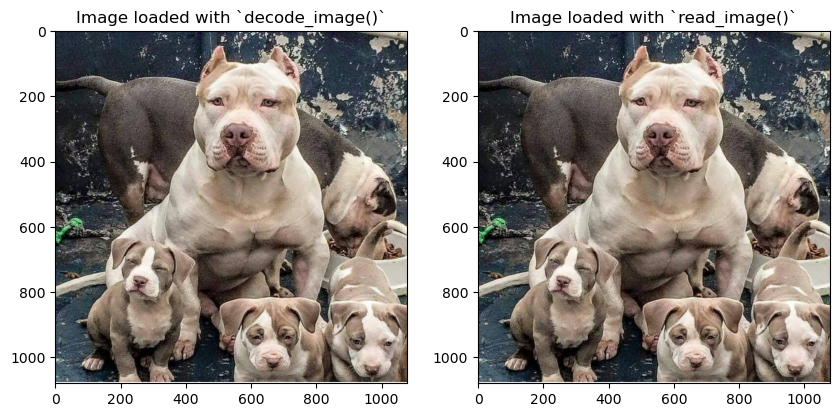

In [109]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Image loaded with `decode_image()`")
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.title("Image loaded with `read_image()`")
plt.imshow(img2.permute(1, 2, 0))

In [17]:
with open(path_to_annotation_cfg, 'r') as file:
    annotation_cfg = yaml.safe_load(file)

labels_map = {0: "background"}
for i, dog_class in enumerate(annotation_cfg["names"]):
    i += 1
    labels_map[i] = dog_class

labels_map

{0: 'background',
 1: 'dogue_de_bordeaux',
 2: 'staffordshire_bullterrier',
 3: 'dogo_argentino',
 4: 'other_dog_breed',
 5: 'cau_ovcharka',
 6: 'person',
 7: 'human_face',
 8: 'am_pit_bull_terrier',
 9: 'fila_brasileiro',
 10: 'bull_terrier',
 11: 'kangal',
 12: 'neapolitan_mastiff',
 13: 'rottweiler',
 14: 'bull_mastiff',
 15: 'mastin_espanol',
 16: 'tosa_inu',
 17: 'am_staffordshire_terrier',
 18: 'mastiff'}

In [18]:
len(labels_map)

19

In [111]:
with open(path_to_annotation_txt, "r") as file:
    annotations = file.read().splitlines()
annotations

['8 0.4855 0.4128 0.9688 0.5725',
 '8 0.6285 0.8774 0.3263 0.2434',
 '8 0.8824 0.7684 0.2352 0.4632',
 '8 0.3905 0.4913 0.7791 0.8924',
 '8 0.2287 0.7905 0.3435 0.4120']

In [112]:
annotations[0]

'8 0.4855 0.4128 0.9688 0.5725'

In [113]:
img_height, img_width = img.shape[1], img.shape[2]

In [114]:
boxes = []
class_ids = []
for i, box in enumerate(annotations):
    class_id = annotations[i].split(" ")[0]
    bbcenter_x, bbcenter_y, width, height = (
        annotations[i].split(" ")[1:][0],
        annotations[i].split(" ")[1:][1],
        annotations[i].split(" ")[1:][2],
        annotations[i].split(" ")[1:][3],
    )
    bbcenter_x_px = float(bbcenter_x) * img_width
    bbcenter_y_px = float(bbcenter_y) * img_height
    width_px = float(width) * img_width
    height_px = float(height) * img_height
    bbox_xywh = [int(bbcenter_x_px), int(bbcenter_y_px), int(width_px), int(height_px)]

    bbox_xyxy = [
        int(bbox_xywh[0] - bbox_xywh[2] / 2),
        int(bbox_xywh[1] - bbox_xywh[3] / 2),
        int(bbox_xywh[0] + bbox_xywh[2] / 2),
        int(bbox_xywh[1] + bbox_xywh[3] / 2),
    ]
    class_ids.append(int(class_id))
    class_ids = [str(id) for id in class_ids]
    boxes.append(bbox_xyxy)

boxes = torch.tensor(boxes)

print(class_ids, boxes)

['8', '8', '8', '8', '8'] tensor([[   1,  136, 1047,  754],
        [ 502,  816,  854, 1078],
        [ 825,  579, 1079, 1079],
        [   0,   48,  841, 1011],
        [  61,  631,  431, 1075]])


In [115]:
print(class_id, bbcenter_x, bbcenter_y, width, height)

8 0.2287 0.7905 0.3435 0.4120


In [116]:

print(type(class_ids))
print(class_ids)

<class 'list'>
['8', '8', '8', '8', '8']


In [117]:
#print(boxes.shape)

print(boxes.shape)

torch.Size([5, 4])


In [136]:
print(f"Type of class_ids: {type(class_ids)}")
print(f"class_ids len: {len(class_ids)}")
print(f"class_ids: {class_ids}")
print(f"Type of boxes: {type(boxes)}")
print(f"boxes shape: {boxes.shape}")
#print(f"Type of box: {type(boxes[0])}")
print(f"boxes: {boxes}")
print(f"Type of image: {type(img)}")
print(f"img shape: {img.shape}")

Type of class_ids: <class 'list'>
class_ids size: 5
class_ids: ['8', '8', '8', '8', '8']
Type of boxes: <class 'torch.Tensor'>
boxes shape: torch.Size([5, 4])
boxes: tensor([[   1,  136, 1047,  754],
        [ 502,  816,  854, 1078],
        [ 825,  579, 1079, 1079],
        [   0,   48,  841, 1011],
        [  61,  631,  431, 1075]])
Type of image: <class 'torch.Tensor'>
img shape: torch.Size([3, 1080, 1080])


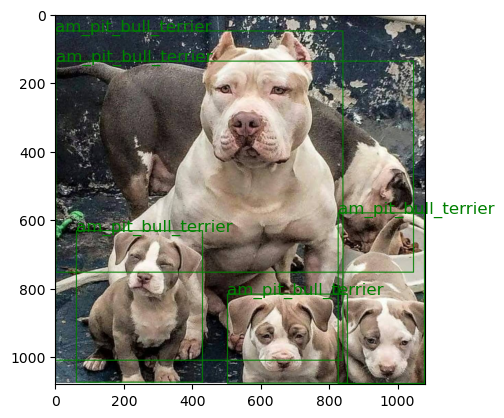

In [121]:
drawn_boxes = draw_bounding_boxes(img, boxes, class_ids, colors="green", width=3)

# Anzeige des Bildes
plt.imshow(drawn_boxes.permute(1, 2, 0))
# add class labels in top left corner of bbox
for i, box in enumerate(boxes):
    plt.text(
        box[0],
        box[1],
        f"{labels_map[int(class_ids[i])]}",
        fontsize=12,
        color="green",
    )
plt.axis("on")
plt.show()

In [91]:
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

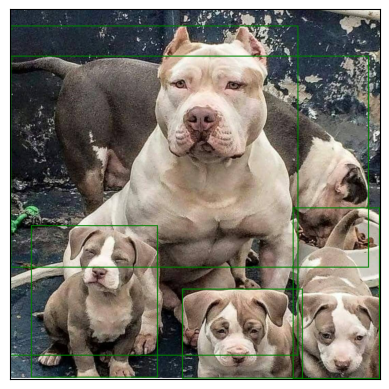

In [93]:
drawn_boxes = draw_bounding_boxes(img, boxes, class_ids , colors="green", width=3)
show(drawn_boxes)

In [124]:
import yaml
from pathlib import Path


def load_classes(yaml_path: str) -> list:
    """
    Load class names from a YAML configuration file.

    Args:
        yaml_path (str): Path to the YAML file.

    Returns:
        list: List of class names.
    """
    with open(yaml_path, "r") as file:
        config = yaml.safe_load(file)

    classes = config.get("names", [])
    if not classes:
        raise ValueError("No 'names' key found in YAML configuration.")
    classes = ["background"] + classes

    return classes


# Example usage
# if __name__ == "__main__":
#     yaml_path = "../data/split_yolo/labels_txt/dataset.yaml"
#     class_names = load_classes(yaml_path)
#     print("Loaded Classes:", class_names)


Loaded Classes: ['background', 'dogue_de_bordeaux', 'staffordshire_bullterrier', 'dogo_argentino', 'other_dog_breed', 'cau_ovcharka', 'person', 'human_face', 'am_pit_bull_terrier', 'fila_brasileiro', 'bull_terrier', 'kangal', 'neapolitan_mastiff', 'rottweiler', 'bull_mastiff', 'mastin_espanol', 'tosa_inu', 'am_staffordshire_terrier', 'mastiff']


In [125]:
def get_dataset_paths(yaml_path: str) -> dict:
    """Get absolute paths for images and labels from YAML config."""
    with open(yaml_path, "r") as file:
        cfg = yaml.safe_load(file)

    # Get base paths
    yaml_dir = Path(yaml_path).parent
    label_base = yaml_dir / cfg["path"]

    # Resolve paths relative to config location
    paths = {
        "train": {"images": yaml_dir / cfg["train"], "labels": label_base / "train"},
        "val": {"images": yaml_dir / cfg["val"], "labels": label_base / "val"},
        "test": {"images": yaml_dir / cfg["test"], "labels": label_base / "test"},
    }

    return paths


# Example usage
yaml_path = "../data/split_yolo/labels_txt/dataset.yaml"
paths = get_dataset_paths(yaml_path)
print(f"Train images: {paths['train']['images']}")
print(f"Train labels: {paths['train']['labels']}")


Train images: ../data/split_yolo/labels_txt/../images/train
Train labels: ../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/train


In [126]:
paths

{'train': {'images': PosixPath('../data/split_yolo/labels_txt/../images/train'),
  'labels': PosixPath('../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/train')},
 'val': {'images': PosixPath('../data/split_yolo/labels_txt/../images/val'),
  'labels': PosixPath('../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/val')},
 'test': {'images': PosixPath('../data/split_yolo/labels_txt/../images/test'),
  'labels': PosixPath('../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/test')}}

In [127]:
def get_dataset_paths(yaml_path: str) -> dict:
    """Get absolute paths for images and labels from YAML config."""
    with open(yaml_path, "r") as file:
        cfg = yaml.safe_load(file)

    yaml_dir = Path(yaml_path).parent.parent  # Go up one level to split_yolo

    paths = {
        "train": {
            "images": (yaml_dir / "images/train").resolve(),
            "labels": (yaml_dir / "labels_txt/train").resolve(),
        },
        "val": {
            "images": (yaml_dir / "images/val").resolve(),
            "labels": (yaml_dir / "labels_txt/val").resolve(),
        },
        "test": {
            "images": (yaml_dir / "images/test").resolve(),
            "labels": (yaml_dir / "labels_txt/test").resolve(),
        },
    }

    return paths


In [128]:
paths

{'train': {'images': PosixPath('../data/split_yolo/labels_txt/../images/train'),
  'labels': PosixPath('../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/train')},
 'val': {'images': PosixPath('../data/split_yolo/labels_txt/../images/val'),
  'labels': PosixPath('../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/val')},
 'test': {'images': PosixPath('../data/split_yolo/labels_txt/../images/test'),
  'labels': PosixPath('../data/split_yolo/labels_txt/../data/split_yolo/labels_txt/test')}}

In [166]:
torch.utils.data.get_worker_info()

## Minimal Implementation Of A Backbone

### Step 1 — Import Dependencies

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

### Step 2 — Define The Backbone


In [3]:
class Backbone(nn.Module):
    def __init__(self, pretrained=True, trainable_layers=3):
        super(Backbone, self).__init__()

        # Load ResNet50 with pre-trained weights
        resnet = resnet50(
            weights=ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        )

        # Extract layers up to the final convolutional block
        self.feature_extractor = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )

        # Optionally freeze some layers for transfer learning
        layers_to_freeze = (
            len(list(self.feature_extractor.children())) - trainable_layers
        )
        for i, layer in enumerate(self.feature_extractor.children()):
            if i < layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, x):
        return self.feature_extractor(x)

### Step 3 — Initialize The Backbone

97.8Mb model will be saved in the `~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth` directory.

In [ ]:
# Create an instance of the backbone
backbone = Backbone(pretrained=True, trainable_layers=3)

# Check the model summary
print(backbone)

### Step 4 — Modifying Pre-Trained Backbones

Sometimes, specific architectures require slight modifications to the backbone (e.g., adding an extra layer or changing the output size). Here’s an example of adding a custom output layer -

In [22]:
# class CustomBackbone(Backbone):
#     def __init__(self, pretrained=True, trainable_layers=3, num_channels=512):
#         super(CustomBackbone, self).__init__(pretrained, trainable_layers)

#         # Add a 1x1 convolutional layer to reduce the output channels
#         self.conv1x1 = nn.Conv2d(2048, num_channels, kernel_size=1)

#     def forward(self, x):
#         features = super(CustomBackbone, self).forward(x)
#         return self.conv1x1(features)

### Step 5 — Testing The Backbone

In [23]:
# Example input (batch of 2 images, 3 channels, 224x224)
dummy_input = torch.randn(2, 3, 224, 224)

# Forward pass
features = backbone(dummy_input)
print("Output feature map size:", features.size())

Output feature map size: torch.Size([2, 2048, 7, 7])


--> 2048*7*7=100352 !!!

#### Key Takeaways

- **Pre-Trained Backbones Save Time**: Leveraging pre-trained weights accelerates convergence, especially with limited data.
- **Customization**: Adding or modifying layers tailors the backbone to specific use cases.
- **Freezing Layers**: Freezing early layers helps focus training on high-level features.

This minimal implementation provides a foundation to build custom object detection pipelines, enabling you to experiment with different architectures and pre-trained models.

## Building A Barebones Detection Head

### Step 1 — Define The Detection Head

The detection head comprises two separate multi-layer perceptrons (MLPs) - one for bounding box regression and another for class prediction.

In [68]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DetectionHead, self).__init__()

        # Bounding box regression head
        self.bbox_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, 512),
            nn.ReLU(),
            nn.Linear(512, 4),  # Output: [x_min, y_min, x_max, y_max]
        )

        # Class prediction head
        self.class_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),  # Output: logits for each class
        )

    def forward(self, x):
        # Bounding box regression
        bbox_predictions = self.bbox_head(x)

        # Class predictions
        class_logits = self.class_head(x)

        return bbox_predictions, class_logits

### Step 2 — Integrate The Head With The Backbone

We now combine the Backbone and DetectionHead to create a complete object detection model.

In [69]:
class BarebonesObjectDetector(nn.Module):
    def __init__(self, backbone, num_classes):
        super(BarebonesObjectDetector, self).__init__()
        self.backbone = backbone
        self.detection_head = DetectionHead(
            # in_channels=512, num_classes=num_classes
            in_channels=100352, num_classes=num_classes
        )

    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x)

        # Forward pass through the detection head
        bbox_predictions, class_logits = self.detection_head(features)

        return bbox_predictions, class_logits

In [71]:
# Define the number of classes (e.g., all object classes + 1 background class)
num_classes = 19
#num_classes = len(labels_map)

# Use the backbone implemented earlier
backbone = Backbone(pretrained=True, trainable_layers=3)


feature_map_size = 2048 * 7 * 7

# Create the full object detection model
model = BarebonesObjectDetector(backbone, num_classes)

# Print the model architecture
#print(model)

### Step 4 — Testing The Model

We’ll pass a dummy batch of images through the model to verify its functionality.

In [72]:
# Example input (batch of 2 images, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224)
print(f"Input shape: {dummy_input.shape}")

features = backbone(dummy_input)
print(f"Backbone output shape: {features.shape}")

Input shape: torch.Size([1, 3, 224, 224])
Backbone output shape: torch.Size([1, 2048, 7, 7])


In [66]:
# Forward pass
bbox_predictions, class_logits = model(dummy_input)

# Output sizes
print("Bounding Box Predictions:", bbox_predictions.size())  # Should be [batch_size, 4]
print("Class Predictions:", class_logits.size())  # Should be [batch_size, num_classes]

Bounding Box Predictions: torch.Size([1, 4])
Class Predictions: torch.Size([1, 10])


### Implementing Forward Passes & Loss Functions

#### Overview

A forward pass in an object detection (OD) model involves:

- Passing input images through the backbone to extract features.
- Feeding these features into the detection head to predict bounding boxes and class logits.
- Calculating losses for bounding box regression and classification.

We’ll implement this step-by-step using PyTorch, covering the forward pass and loss computation.

#### Forward Pass — From Input To Predictions

The forward pass uses the combined backbone and detection head implemented earlier. For training, we also require ground truth annotations for bounding boxes and class labels.

In [73]:
def forward_pass(model, images, targets=None):
    """
    Perform a forward pass through the model.

    Args:
        model (nn.Module): The object detection model.
        images (torch.Tensor): Input images of shape [batch_size, channels, height, width].
        targets (dict): Ground truth with keys 'boxes' and 'labels'.

    Returns:
        Tuple: Predicted bounding boxes and class logits (during inference),
               or total loss (during training).
    """
    # Perform forward pass through the model
    bbox_predictions, class_logits = model(images)

    if targets:
        # If training, compute losses
        loss = compute_losses(bbox_predictions, class_logits, targets)
        return loss
    else:
        # If inference, return predictions
        return bbox_predictions, class_logits

#### Loss Functions

##### Bounding Box Regression Loss

We use **Smooth L1 Loss** (Huber Loss), which balances sensitivity to outliers while penalizing larger errors more significantly.
##### Classification Loss

We use **Cross-Entropy Loss** for class logits. It measures the difference between predicted class probabilities and true labels.

##### Implementing The Loss Functions

In [74]:
def compute_losses(bbox_predictions, class_logits, targets):
    """
    Compute the total loss for bounding box regression and classification.

    Args:
        bbox_predictions (torch.Tensor): Predicted bounding boxes, shape [batch_size, 4].
        class_logits (torch.Tensor): Predicted class logits, shape [batch_size, num_classes].
        targets (dict): Ground truth with keys:
            - 'boxes': Ground truth bounding boxes, shape [batch_size, 4].
            - 'labels': Ground truth class labels, shape [batch_size].

    Returns:
        torch.Tensor: Total loss (sum of regression and classification losses).
    """
    # Smooth L1 Loss for bounding box regression
    bbox_loss_fn = nn.SmoothL1Loss()
    bbox_loss = bbox_loss_fn(bbox_predictions, targets["boxes"])

    # Cross-Entropy Loss for classification
    class_loss_fn = nn.CrossEntropyLoss()
    class_loss = class_loss_fn(class_logits, targets["labels"])

    # Total loss
    total_loss = bbox_loss + class_loss
    return total_loss

##### Training Example — Calculating Total Loss

Let’s simulate a training step with dummy data.

In [75]:
# Initialize the model
num_classes = 19  # Example: 18 object classes + 1 background
model = BarebonesObjectDetector(backbone, num_classes)

# Example input images (batch of 2, RGB, 224x224)
images = torch.randn(2, 3, 224, 224)

# Ground truth (dummy data)
targets = {
    "boxes": torch.tensor(
        [[50, 60, 150, 200], [30, 40, 120, 160]], dtype=torch.float32
    ),  # Shape: [batch_size, 4]
    "labels": torch.tensor([3, 5], dtype=torch.long),  # Shape: [batch_size]
}

# Forward pass and compute loss
loss = forward_pass(model, images, targets)
print(f"Total Loss: {loss.item()}")

Total Loss: 103.7550048828125


### Customizing Anchor Generation & NMS

#### Code For Anchor Creation:

In [76]:
import torch


def generate_anchors(
    base_size=16, scales=[0.5, 1.0, 2.0], aspect_ratios=[0.5, 1.0, 2.0]
):
    """
    Generate anchor boxes based on scales and aspect ratios.

    Args:
        base_size (int): The size of the base anchor.
        scales (list): Scaling factors for anchors.
        aspect_ratios (list): Aspect ratios for anchors.

    Returns:
        torch.Tensor: Generated anchors of shape [num_anchors, 4] (x_min, y_min, x_max, y_max).
    """
    anchors = []
    for scale in scales:
        for ratio in aspect_ratios:
            w = base_size * scale * (ratio**0.5)
            h = base_size * scale / (ratio**0.5)
            x_min, y_min = -w / 2, -h / 2
            x_max, y_max = w / 2, h / 2
            anchors.append([x_min, y_min, x_max, y_max])

    return torch.tensor(anchors, dtype=torch.float32)


# Example usage
anchors = generate_anchors()
print(anchors)

tensor([[ -2.8284,  -5.6569,   2.8284,   5.6569],
        [ -4.0000,  -4.0000,   4.0000,   4.0000],
        [ -5.6569,  -2.8284,   5.6569,   2.8284],
        [ -5.6569, -11.3137,   5.6569,  11.3137],
        [ -8.0000,  -8.0000,   8.0000,   8.0000],
        [-11.3137,  -5.6569,  11.3137,   5.6569],
        [-11.3137, -22.6274,  11.3137,  22.6274],
        [-16.0000, -16.0000,  16.0000,  16.0000],
        [-22.6274, -11.3137,  22.6274,  11.3137]])


#### Code for NMS In PyTorch:

In [ ]:
from torchvision.io import decode_image, decode_jpeg, read_image
from torchvision.utils import draw_bounding_boxes

In [77]:
def non_maximum_suppression(boxes, scores, iou_threshold=0.5):
    """
    Perform non-maximum suppression (NMS) on bounding boxes.

    Args:
        boxes (torch.Tensor): Predicted boxes, shape [num_boxes, 4].
        scores (torch.Tensor): Confidence scores, shape [num_boxes].
        iou_threshold (float): IoU threshold for NMS.

    Returns:
        torch.Tensor: Indices of the retained boxes.
    """
    indices = torch.argsort(scores, descending=True)
    keep = []

    while indices.numel() > 0:
        current = indices[0]
        keep.append(current)

        if indices.numel() == 1:
            break

        remaining_boxes = boxes[indices[1:]]
        iou = calculate_iou(boxes[current].unsqueeze(0), remaining_boxes)
        indices = indices[1:][iou < iou_threshold]

    return torch.tensor(keep, dtype=torch.long)

#### Code for calculating IOU In PyTorch:

In [78]:
def calculate_iou(box1, box2):
    """
    Compute IoU between two sets of boxes.

    Args:
        box1 (torch.Tensor): Single box, shape [1, 4].
        box2 (torch.Tensor): Multiple boxes, shape [N, 4].

    Returns:
        torch.Tensor: IoU scores for each box in box2.
    """
    inter = (
        torch.min(box1[:, 2], box2[:, 2]) - torch.max(box1[:, 0], box2[:, 0])
    ).clamp(0) * (
        torch.min(box1[:, 3], box2[:, 3]) - torch.max(box1[:, 1], box2[:, 1])
    ).clamp(0)

    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    union = box1_area + box2_area - inter
    return inter / union

### Training The Model With Custom Pipelines

#### Code Example — Custom Dataset Class

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class CustomObjectDetectionDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        """
        Args:
            annotations (list): List of dictionaries containing image paths and labels.
            image_dir (str): Directory with all the images.
            transform (callable, optional): Transformations to be applied on a sample.
        """
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_path = f"{self.image_dir}/{annotation['image_name']}"
        image = Image.open(image_path).convert("RGB")
        boxes = torch.tensor(annotation["boxes"], dtype=torch.float32)
        labels = torch.tensor(annotation["labels"], dtype=torch.long)

        sample = {"image": image, "boxes": boxes, "labels": labels}

        if self.transform:
            sample["image"] = self.transform(sample["image"])

        return sample


# Example Usage
transform = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])

# dataset = CustomObjectDetectionDataset(annotations, "data/images", transform)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
from pathlib import Path
import yaml
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms


class DogBreedDataset(Dataset):
    def __init__(self, yaml_path: str, split: str = "train", transform=None):
        """Initialize dataset from YAML config."""
        # Load config
        with open(yaml_path, "r") as f:
            self.cfg = yaml.safe_load(f)
        print(f"YAML config contents: {self.cfg}")

        # Setup paths
        self.config_dir = Path(yaml_path).parent
        self.img_dir = self.config_dir / ".." / self.cfg[split]
        self.label_dir = self.config_dir / split

        # Add to __init__
        print(f"Image directory exists: {self.img_dir.exists()}")
        print(f"Label directory exists: {self.label_dir.exists()}")

        # Get file lists
        self.img_files = sorted(list(self.img_dir.glob("*.jpg")))
        self.label_files = sorted(list(self.label_dir.glob("*.txt")))

        self.transform = transform

        # Validate
        assert len(self.img_files) == len(self.label_files), (
            "Mismatch between images and labels"
        )
        self.validate_pairs()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")

        # Load annotation
        label_path = self.label_files[idx]
        with open(label_path) as f:
            label = f.read().strip().split("\n")

        # Parse annotations (class_id, x, y, w, h)
        targets = []
        for line in label:
            class_id, *bbox = map(float, line.split())
            targets.append([class_id, *bbox])

        targets = torch.tensor(targets)

        if self.transform:
            image = self.transform(image)

        return image, targets

    def validate_pairs(self):
        img_names = {f.stem for f in self.img_files}
        label_names = {f.stem for f in self.label_files}
        missing_labels = img_names - label_names
        missing_images = label_names - img_names
        if missing_labels:
            print(f"Images missing labels: {missing_labels}")
        if missing_images:
            print(f"Labels missing images: {missing_images}")


# Example usage
yaml_path = "../data/split_yolo/labels_txt/dataset.yaml"
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

train_dataset = DogBreedDataset(yaml_path, split="train", transform=transform)
print(f"Dataset size: {len(train_dataset)}")
img, target = train_dataset[0]
print(f"Image shape: {img.shape}")
print(f"Target shape: {target.shape}")


In [135]:
yaml_path

'../data/split_yolo/labels_txt/dataset.yaml'